# Image classification with 'image_dataset_from_directory' method

# Creating train/val/test datasets using split-folders package

The split-folders package allow us to create 3 folders of train/val/test images

The input folder should have the following format (Gregoire's function output):

input/

    class1/
        img1.jpg
        img2.jpg
        ...
    class2/
        imgWhatever.jpg
        ...
    ...
    
    
And we get this

output/

    train/
        class1/
            img1.jpg
            ...
        class2/
            imga.jpg
            ...
            
    val/
    
        class1/
        
            img2.jpg
            ...
        class2/
            imgb.jpg
            ...
    test/
        class1/
            img3.jpg
            ...
        class2/
            imgc.jpg
            ...

In [52]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

assert TRAIN_RATIO + VAL_RATIO + TEST_RATIO == 1
assert TRAIN_RATIO != 0
assert VAL_RATIO != 0
assert TEST_RATIO != 0

In [53]:
import splitfolders
!rm -rf "/home/jupyter/wikiart/train_val_test_True_1440"
splitfolders.ratio("/home/jupyter/wikiart/wikiart-movement-genre_True-class_8-merge_mov-1-n_1440_max", 
                   output="/home/jupyter/wikiart/train_val_test_True_1440",
                   seed=1337, ratio=(TRAIN_RATIO, VAL_RATIO, TEST_RATIO), 
                   group_prefix=None);

Copying files: 11520 files [00:03, 2947.15 files/s]


# Deep learning workflow

## Imports

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, models, applications

# Note : we are using TensorFlow Core v2.5.0, in TensorFlow Core v2.6.0 all the data augmentaation layers are part of tf.keras.layers
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax

## Global variables

In [86]:
USERNAME = 'pablo'
MODEL = 'ResNet50'

MAIN_PATH = '/home/jupyter/' 
DATASETS_FOLDER = 'wikiart/train_val_test_True_1440/'

TRAIN_DIR = MAIN_PATH + DATASETS_FOLDER + 'train'
VAL_DIR = MAIN_PATH + DATASETS_FOLDER + 'val'
TEST_DIR = MAIN_PATH + DATASETS_FOLDER + 'test'

In [87]:
BATCH_SIZE = 128
EPOCHS = 1000
IMG_HEIGHT = 224
IMG_WIDTH = 224
NUM_CLASSES = 8

## Datasets setup

### Train dataset

In [57]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=TRAIN_DIR,
    labels='inferred',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True)

assert len(train_ds.class_names) == NUM_CLASSES

Found 9216 files belonging to 8 classes.


### Validation dataset

In [58]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=VAL_DIR,
    labels='inferred',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    label_mode='categorical',
    batch_size=BATCH_SIZE)

assert len(val_ds.class_names) == NUM_CLASSES

Found 1152 files belonging to 8 classes.


### Test dataset

In [59]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=TEST_DIR,
    labels='inferred',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    label_mode='categorical',
    batch_size=BATCH_SIZE)

assert len(test_ds.class_names) == NUM_CLASSES

Found 1152 files belonging to 8 classes.


In [60]:
total_images_count = (int(len(list(train_ds)))+int(len(list(val_ds)))+int(len(list(test_ds))))*BATCH_SIZE
# total_images_count = 33011 + 4123 + 4134
total_images_count

11520

## Dataset optimization for performance

In [88]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(int(total_images_count/10)).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model : transfer learning with ResNet50

### ResNet50 layers

In [89]:
layer_model = applications.ResNet50(
    include_top=False, 
    weights='imagenet', 
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), 
    classes=NUM_CLASSES)

In [90]:
layer_model.layers[-4:]

In [91]:
layer_model.layers[-3]

In [92]:
layer_model.trainable = False

In [93]:
for layer in layer_model.layers[-4:]:
    layer.trainable = True

In [94]:
layer_model.layers[-3].trainable = False

In [95]:
trainable_layer_count = 0

for i in range(len(layer_model.layers)):
    if layer_model.layers[i].trainable:
        trainable_layer_count += 1
        
trainable_layer_count

3

### Data augmentation layers

In [96]:
data_augmentation_layers = models.Sequential([
    RandomFlip("horizontal", input_shape=(224, 224,3)),
    RandomRotation(0.3),
    RandomZoom(0.3)])

### Model setup

In [97]:
tf.keras.backend.clear_session() # Clear the layers name (in case you run multiple time the cell)

inputs = Input(shape=(224, 224, 3))

x = data_augmentation_layers(inputs) # Are not applied to validation and test dataset (made inactive, tensorflow handle it)
x = applications.resnet50.preprocess_input(x) # Does the rescaling
x = layer_model(x) 
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x) 

outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='classification_layer')(x)

model = Model(inputs, outputs)

### Callbacks

#### EarlyStopping

In [98]:
es = EarlyStopping(monitor='val_loss', patience=20, mode='min', restore_best_weights=True)

#### ReduceLROnPlateau

In [99]:
rlrp = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=5, min_lr=1e-8)

#### ModelCheckpoint

In [100]:
checkpoint_dir = f"{MAIN_PATH}logs/{USERNAME}/{MODEL}/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + f"-unfreeze_{trainable_layer_count}"
mcp = ModelCheckpoint(
    filepath=checkpoint_dir,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_freq=10,
    save_best_only=True)

In [101]:
%load_ext tensorboard
# !rm -rf ./logs/ResNet50
recorded_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
log_dir = f"{MAIN_PATH}logs/{USERNAME}/{MODEL}/" + \
    recorded_time + \
    f"-images_{total_images_count}" + \
    f"-unfreeze_{trainable_layer_count}" + \
    f"-batch_{BATCH_SIZE}"
tsboard = TensorBoard(log_dir=log_dir) # voir https public

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Model compilation

In [102]:
model.compile(optimizer=Adamax(learning_rate=0.01), 
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

### Model fitting

In [103]:
history = model.fit(
    train_ds, 
    epochs=EPOCHS, 
    validation_data=val_ds, 
    callbacks=[es, rlrp, tsboard], 
    use_multiprocessing=True)

model.save(f"{MAIN_PATH}models/{USERNAME}/{MODEL}/" + \
    recorded_time + \
    f"-images_{total_images_count}" + \
    f"-unfreeze_{trainable_layer_count}" + \
    f"-batch_{BATCH_SIZE}")

Epoch 1/1000
288/288 [==============================] - 58s 123ms/step - loss: 1.8789 - accuracy: 0.4827 - val_loss: 1.1797 - val_accuracy: 0.5920
Epoch 2/1000
288/288 [==============================] - 33s 116ms/step - loss: 1.5182 - accuracy: 0.5569 - val_loss: 1.2496 - val_accuracy: 0.5885
Epoch 3/1000
288/288 [==============================] - 33s 116ms/step - loss: 1.5039 - accuracy: 0.5640 - val_loss: 1.2723 - val_accuracy: 0.6120
Epoch 4/1000
288/288 [==============================] - 33s 116ms/step - loss: 1.4618 - accuracy: 0.5752 - val_loss: 1.1622 - val_accuracy: 0.6172
Epoch 5/1000
288/288 [==============================] - 33s 116ms/step - loss: 1.4594 - accuracy: 0.5749 - val_loss: 1.2789 - val_accuracy: 0.5885
Epoch 6/1000
288/288 [==============================] - 33s 116ms/step - loss: 1.4564 - accuracy: 0.5742 - val_loss: 1.2359 - val_accuracy: 0.6198
Epoch 7/1000
288/288 [==============================] - 33s 116ms/step - loss: 1.4861 - accuracy: 0.5742 - val_loss: 1

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /home/jupyter/models/pablo/ResNet50/20210830-103448-images_11520-unfreeze_3-batch_128/assets


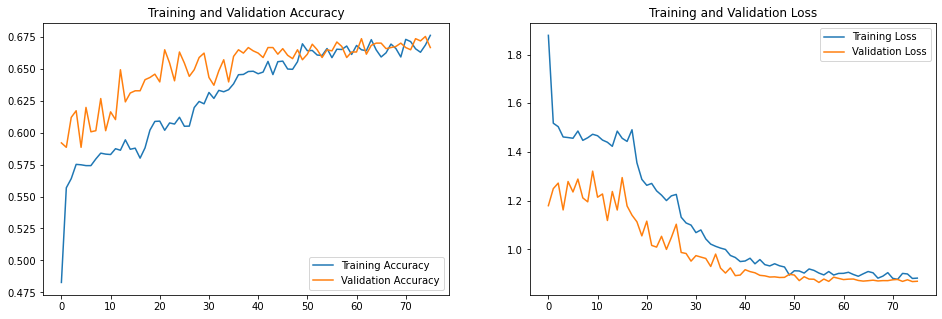

In [109]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

fig = plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
fig.savefig(f"/home/jupyter/figures/{USERNAME}/{MODEL}/{recorded_time}-images_{total_images_count}-unfreeze_{trainable_layer_count}-batch_{BATCH_SIZE}", dpi=300)

In [105]:
model_resnet50.evaluate(test_ds, callbacks=tsboard)

NameError: name 'model_resnet50' is not defined